# Importing the needed Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import folium
from scipy.stats import pearsonr
from folium import plugins
from folium.plugins import HeatMap
from folium.plugins import HeatMapWithTime
import calendar
from matplotlib.ticker import FuncFormatter
import datetime
import joblib
import xgboost as xgb
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
import statsmodels
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Loading and Processing Data for Treated Water

In [2]:
flow = pd.read_excel('Kay Bailey.xlsx')

flow.head()

,Year,Month,Date,Airport Wells,Gal Units1,Total Flow1,Ft. Bliss Wells,Gal Units2,Total Flow2,Concentrate,Gal Units3,Total Flow3,Finished Water,Gal Units4,Total Flow4,CL2
0,2018,January,1,752138,7226,7.226,667672,2288,2.288,5180688,1276.0,1.276,577652,8365,8.365,1.34
1,2018,January,2,759308,7170,7.170,669948,2276,2.276,5181946,1258.0,1.258,585965,8313,8.313,1.31
2,2018,January,3,766545,7237,7.237,672235,2287,2.287,5183231,1285.0,1.285,594306,8341,8.341,1.31
3,2018,January,4,773753,7208,7.208,674512,2277,2.277,5184502,1271.0,1.271,602624,8318,8.318,1.32
4,2018,January,5,780945,7192,7.192,676795,2283,2.283,5185769,1267.0,1.267,610943,8319,8.319,1.31


In [3]:
column_data_types = flow.dtypes

# Print the data types
print("Data types of each column in the in predictors DataFrame:")
print(column_data_types)

Data types of each column in the in predictors DataFrame:
Year                  int64
Month                object
Date                  int64
Airport Wells         int64
Gal Units1            int64
Total Flow1         float64
Ft. Bliss Wells       int64
Gal Units2            int64
Total Flow2         float64
Concentrate           int64
Gal Units3          float64
Total Flow3         float64
Finished Water       object
Gal Units4            int64
Total Flow4         float64
CL2                 float64
dtype: object


# Loading and Processing data for Energy Consumption

In [4]:
energy= pd.read_excel('KBH 071923 RQT 2.xlsx')

energy.head()

,Year,Month,KWH,Billed $,$/KWH,Water Kgal,KWH/Kgal,E Billed per Kgal
0,2016,Jan,408581.0,30450.81,0.074528,130239.0,3.137163,0.233807
1,2016,Feb,384347.0,28710.77,0.074700,118555.0,3.241930,0.242173
2,2016,Mar,637308.0,46868.25,0.073541,195349.0,3.262407,0.239921
3,2016,Apr,769057.0,56103.62,0.072951,217626.0,3.533847,0.257798
4,2016,May,794757.0,58179.68,0.073204,271849.0,2.923524,0.214015


In [5]:
column_data_types = energy.dtypes

# Print the data types
print("Data types of each column in the in predictors DataFrame:")
print(column_data_types)
print(len(energy))

Data types of each column in the in predictors DataFrame:
Year                   int64
Month                 object
KWH                  float64
Billed $             float64
$/KWH                float64
Water Kgal           float64
KWH/Kgal             float64
E Billed per Kgal    float64
dtype: object
89


In [6]:
# Convert Month, Day, and Year columns to a datetime format
flow['Date'] = pd.to_datetime(flow['Year'].astype(str) + '-' + flow['Month'].astype(str) + '-' + flow['Date'].astype(str), errors='coerce')

In [7]:
# Create 'Date' column from 'Year' and 'Month'
num_rows = len(energy)
energy['Date'] = pd.date_range(start='2016-01-01', periods=num_rows, freq='MS')

In [8]:
# Check for missing values in each column of flow_data
missing_values = flow.isna().sum()
print("Missing values in each column before removal:")
print(missing_values)

Missing values in each column before removal:
Year                0
Month               0
Date                0
Airport Wells       0
Gal Units1          0
Total Flow1         0
Ft. Bliss Wells     0
Gal Units2          0
Total Flow2         0
Concentrate         0
Gal Units3          0
Total Flow3         0
Finished Water      0
Gal Units4          0
Total Flow4         0
CL2                 0
dtype: int64


# Other Data Preprocessing Steps

In [9]:
# Check for missing values in each column of flow_data
missing_values = energy.isna().sum()
print("Missing values in each column before removal:")
print(missing_values)

Missing values in each column before removal:
Year                 0
Month                0
KWH                  0
Billed $             0
$/KWH                1
Water Kgal           2
KWH/Kgal             2
E Billed per Kgal    3
Date                 0
dtype: int64


In [10]:
# Filling missing values

# For '/KWH' column, we'll fill with the mean
energy['$/KWH'].fillna(energy['$/KWH'].mean(), inplace=True)

# For 'Water Kgal' column, we'll fill with the mean
energy['Water Kgal'].fillna(energy['Water Kgal'].mean(), inplace=True)

# For 'KWH/Kgal' column, we'll fill with the mean
energy['KWH/Kgal'].fillna(energy['KWH/Kgal'].mean(), inplace=True)

# For 'E Billed per Kgal' column, we'll fill with the mean
energy['E Billed per Kgal'].fillna(energy['E Billed per Kgal'].mean(), inplace=True)

# Checking if all missing values are filled
print(energy.isnull().sum())

Year                 0
Month                0
KWH                  0
Billed $             0
$/KWH                0
Water Kgal           0
KWH/Kgal             0
E Billed per Kgal    0
Date                 0
dtype: int64


In [11]:
flow = pd.get_dummies(flow, columns=['Month'], drop_first=True)

In [12]:
energy = pd.get_dummies(energy, columns=['Month'], drop_first=True)

In [13]:
column_data_types = flow.dtypes

# Print the data types
print("Data types of each column in the in predictors DataFrame:")
print(column_data_types)

Data types of each column in the in predictors DataFrame:
Year                         int64
Date                datetime64[ns]
Airport Wells                int64
Gal Units1                   int64
Total Flow1                float64
Ft. Bliss Wells              int64
Gal Units2                   int64
Total Flow2                float64
Concentrate                  int64
Gal Units3                 float64
Total Flow3                float64
Finished Water              object
Gal Units4                   int64
Total Flow4                float64
CL2                        float64
Month_August                  bool
Month_December                bool
Month_February                bool
Month_January                 bool
Month_July                    bool
Month_June                    bool
Month_March                   bool
Month_May                     bool
Month_November                bool
Month_October                 bool
Month_September               bool
dtype: object


In [14]:
column_data_types = energy.dtypes

# Print the data types
print("Data types of each column in the in predictors DataFrame:")
print(column_data_types)

Data types of each column in the in predictors DataFrame:
Year                          int64
KWH                         float64
Billed $                    float64
$/KWH                       float64
Water Kgal                  float64
KWH/Kgal                    float64
E Billed per Kgal           float64
Date                 datetime64[ns]
Month_Aug                      bool
Month_Dec                      bool
Month_Feb                      bool
Month_Feb                      bool
Month_Jan                      bool
Month_Jan                      bool
Month_Jul                      bool
Month_Jun                      bool
Month_Mar                      bool
Month_May                      bool
Month_Nov                      bool
Month_Oct                      bool
Month_Sep                      bool
dtype: object


In [15]:
def convert_to_numeric(column):
    """Convert a column to numeric, non-numeric becomes NaN."""
    return pd.to_numeric(column, errors='coerce')

# Apply this function to every column in flow
for col in flow.columns:
    if flow[col].dtype == 'object':
        flow[col] = convert_to_numeric(flow[col])

In [16]:
column_data_types = flow.dtypes

# Print the data types
print("Data types of each column in the in predictors DataFrame:")
print(column_data_types)

Data types of each column in the in predictors DataFrame:
Year                         int64
Date                datetime64[ns]
Airport Wells                int64
Gal Units1                   int64
Total Flow1                float64
Ft. Bliss Wells              int64
Gal Units2                   int64
Total Flow2                float64
Concentrate                  int64
Gal Units3                 float64
Total Flow3                float64
Finished Water             float64
Gal Units4                   int64
Total Flow4                float64
CL2                        float64
Month_August                  bool
Month_December                bool
Month_February                bool
Month_January                 bool
Month_July                    bool
Month_June                    bool
Month_March                   bool
Month_May                     bool
Month_November                bool
Month_October                 bool
Month_September               bool
dtype: object


In [17]:
# Check for missing values in each column of flow_data
missing_values = flow.isna().sum()
print("Missing values in each column before removal:")
print(missing_values)

Missing values in each column before removal:
Year                0
Date                0
Airport Wells       0
Gal Units1          0
Total Flow1         0
Ft. Bliss Wells     0
Gal Units2          0
Total Flow2         0
Concentrate         0
Gal Units3          0
Total Flow3         0
Finished Water      1
Gal Units4          0
Total Flow4         0
CL2                 0
Month_August        0
Month_December      0
Month_February      0
Month_January       0
Month_July          0
Month_June          0
Month_March         0
Month_May           0
Month_November      0
Month_October       0
Month_September     0
dtype: int64


In [19]:
# Fill missing values using forward fill method
flow.fillna(method='ffill', inplace=True)

In [20]:
# Check for missing values in each column of flow_data
missing_values = flow.isna().sum()
print("Missing values in each column before removal:")
print(missing_values)

Missing values in each column before removal:
Year                0
Date                0
Airport Wells       0
Gal Units1          0
Total Flow1         0
Ft. Bliss Wells     0
Gal Units2          0
Total Flow2         0
Concentrate         0
Gal Units3          0
Total Flow3         0
Finished Water      0
Gal Units4          0
Total Flow4         0
CL2                 0
Month_August        0
Month_December      0
Month_February      0
Month_January       0
Month_July          0
Month_June          0
Month_March         0
Month_May           0
Month_November      0
Month_October       0
Month_September     0
dtype: int64


In [21]:
print(flow.columns)

Index(['Year', 'Date', 'Airport Wells ', 'Gal Units1', 'Total Flow1',
       'Ft. Bliss Wells ', 'Gal Units2', 'Total Flow2', 'Concentrate',
       'Gal Units3', 'Total Flow3', 'Finished Water', 'Gal Units4',
       'Total Flow4', 'CL2', 'Month_August', 'Month_December',
       'Month_February', 'Month_January', 'Month_July', 'Month_June',
       'Month_March', 'Month_May', 'Month_November', 'Month_October',
       'Month_September'],
      dtype='object')


In [22]:
column_data_types = flow.dtypes

# Print the data types
print("Data types of each column in the in predictors DataFrame:")
print(column_data_types)

Data types of each column in the in predictors DataFrame:
Year                         int64
Date                datetime64[ns]
Airport Wells                int64
Gal Units1                   int64
Total Flow1                float64
Ft. Bliss Wells              int64
Gal Units2                   int64
Total Flow2                float64
Concentrate                  int64
Gal Units3                 float64
Total Flow3                float64
Finished Water             float64
Gal Units4                   int64
Total Flow4                float64
CL2                        float64
Month_August                  bool
Month_December                bool
Month_February                bool
Month_January                 bool
Month_July                    bool
Month_June                    bool
Month_March                   bool
Month_May                     bool
Month_November                bool
Month_October                 bool
Month_September               bool
dtype: object


# Time plot and seasonal decomposition for Treated Water

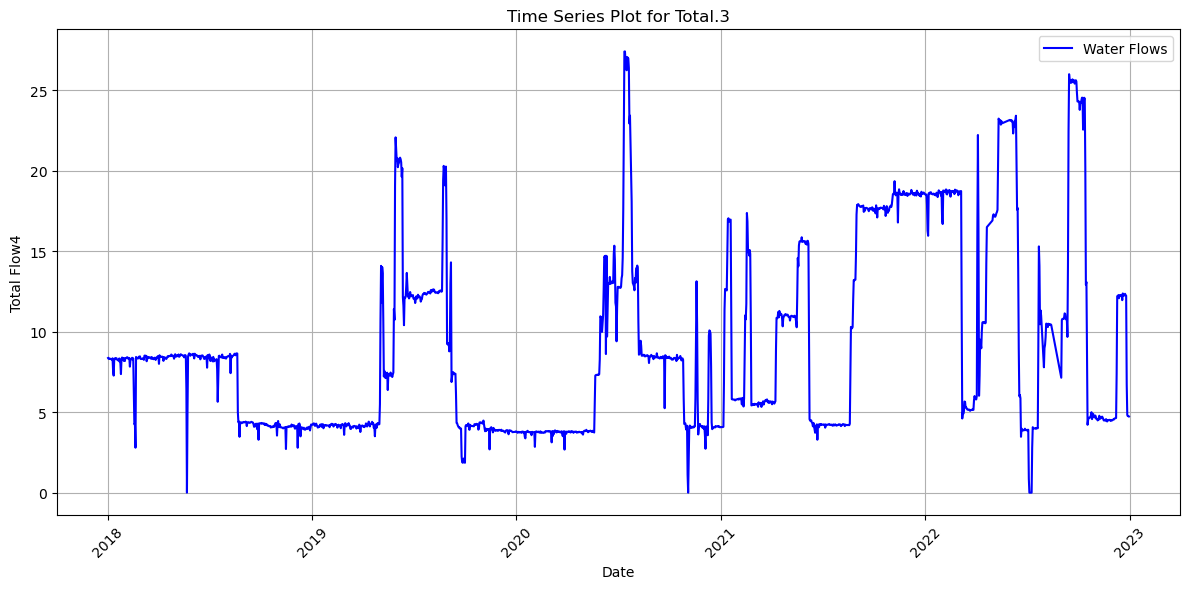

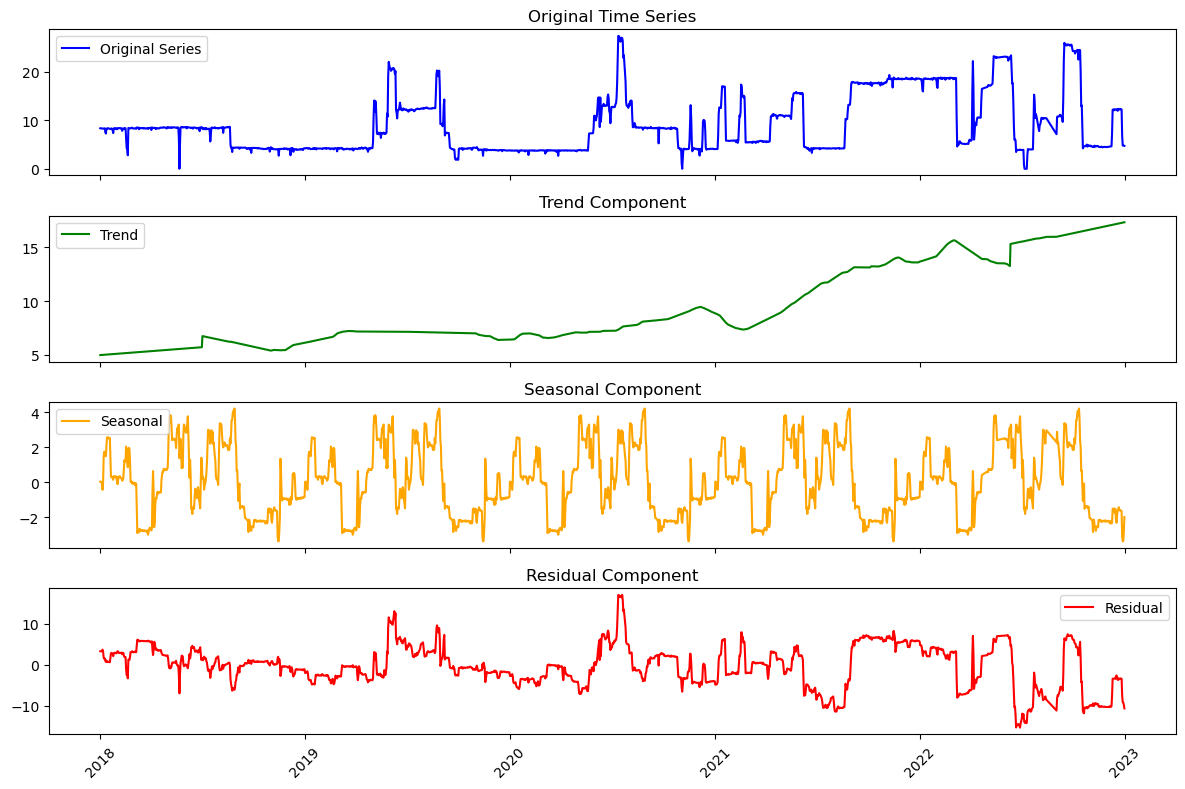

In [23]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Decompose the 'Total.3' series
decomposition = seasonal_decompose(flow['Total Flow4'], period=365, extrapolate_trend='freq')

# Time series plot for 'Total.3'
plt.figure(figsize=(12, 6))
plt.plot(flow['Date'], flow['Total Flow4'], label='Water Flows', color='blue')
plt.title('Time Series Plot for Total.3')
plt.xlabel('Date')
plt.ylabel('Total Flow4')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45) 
plt.tight_layout()

# Extract the components
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Create subplots for each component along with the original time series
fig, axes = plt.subplots(4, 1, sharex=True, figsize=(12, 8))

# Original Time Series
axes[0].plot(flow['Date'], flow['Total Flow4'], label='Original Series', color='blue')
axes[0].set_title('Original Time Series')
axes[0].legend()

# Trend
axes[1].plot(flow['Date'], trend, label='Trend', color='green')
axes[1].set_title('Trend Component')
axes[1].legend()

# Seasonal
axes[2].plot(flow['Date'], seasonal, label='Seasonal', color='orange')
axes[2].set_title('Seasonal Component')
axes[2].legend()

# Residual
axes[3].plot(flow['Date'], residual, label='Residual', color='red')
axes[3].set_title('Residual Component')
axes[3].legend()

# Rotate the x-axis labels for better readability
plt.xticks(rotation=45)

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()

# Time Plot and Seasonal Decomposition for Energy Consumption

C:\Users\ROBERTECH\AppData\Local\Temp\ipykernel_9052\1975989127.py:16: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


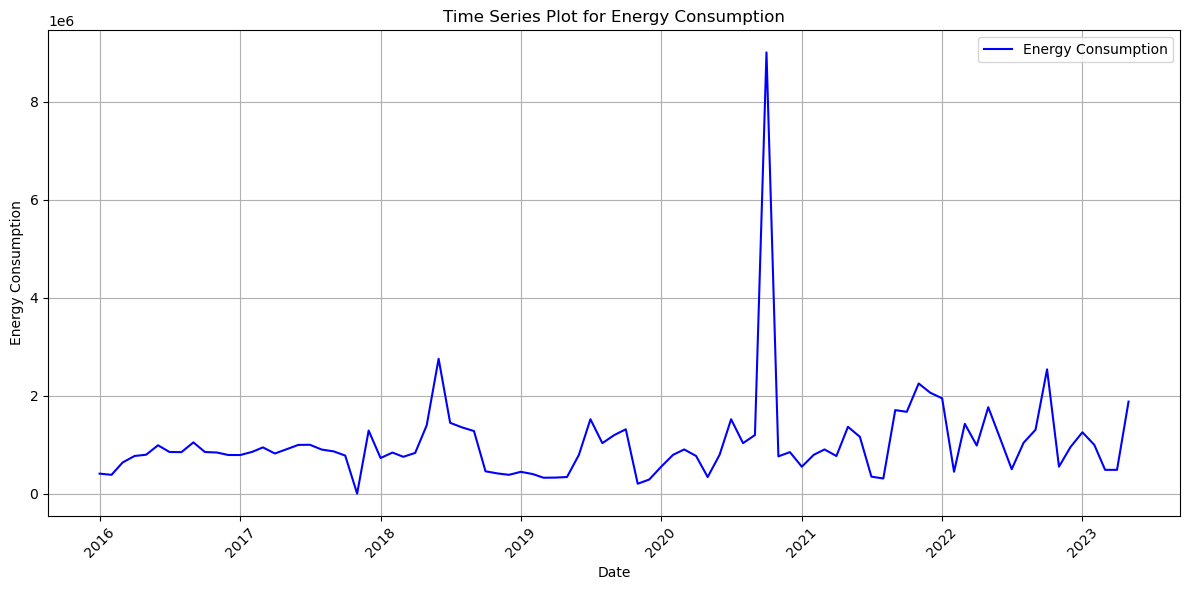

In [24]:

# Time series plot for 'Energy Consumption'
plt.figure(figsize=(12, 6))
plt.plot(energy['Date'], energy['KWH'], label='Energy Consumption', color='blue')
plt.title('Time Series Plot for Energy Consumption')
plt.xlabel('Date')
plt.ylabel('Energy Consumption')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45) 
plt.tight_layout()

# Rotate the x-axis labels for better readability
plt.xticks(rotation=45)

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()

# Exploratory analysis and outlier removal for Energy Consumption

In [25]:
# Display basic statistics
print('\nBasic statistics:')
print(energy.describe())


Basic statistics:
              Year           KWH       Billed $      $/KWH    Water Kgal  \
count    89.000000  8.900000e+01      89.000000  89.000000  8.900000e+01   
mean   2019.224719  1.036080e+06   83301.685056   0.080107  1.406561e+06   
min    2016.000000  0.000000e+00 -422427.010000  -0.554790  1.084730e+05   
25%    2017.000000  5.507330e+05   33126.180000   0.059152  2.171750e+05   
50%    2019.000000  8.501850e+05   56369.480000   0.073541  2.864330e+05   
75%    2021.000000  1.196331e+06  112749.680000   0.092150  2.350390e+06   
max    2023.000000  9.007322e+06  853320.000000   1.000000  6.549870e+06   
std       2.162452  9.957389e+05  119768.279800   0.121736  1.754593e+06   

        KWH/Kgal  E Billed per Kgal                           Date  
count  89.000000          89.000000                             89  
mean    2.507947           0.208788  2019-08-31 22:55:16.853932544  
min     0.000000          -0.306198            2016-01-01 00:00:00  
25%     0.405982    

In [26]:
# Removing outliers beyond 99th percentile
for col in ['KWH']:
    cap = energy[col].quantile(0.99)
    energy = energy[energy[col] <= cap]

C:\Users\ROBERTECH\AppData\Local\Temp\ipykernel_9052\467442065.py:16: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


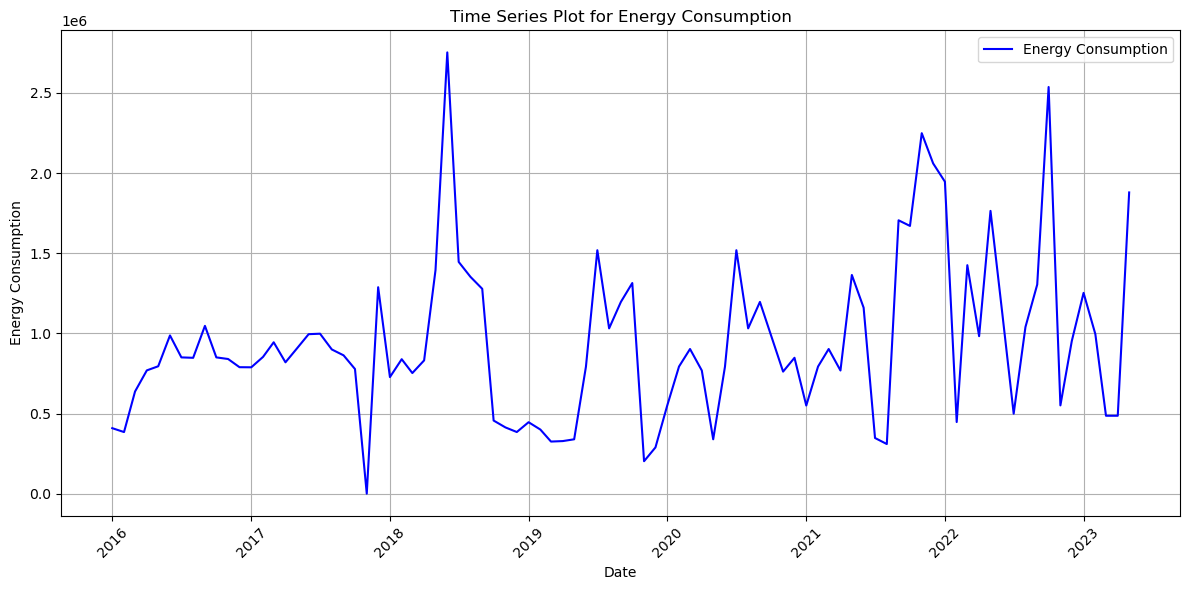

In [27]:
# Time series plot for 'Energy Consumption'
plt.figure(figsize=(12, 6))
plt.plot(energy['Date'], energy['KWH'], label='Energy Consumption', color='blue')
plt.title('Time Series Plot for Energy Consumption')
plt.xlabel('Date')
plt.ylabel('Energy Consumption')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45) 
plt.tight_layout()

# Rotate the x-axis labels for better readability
plt.xticks(rotation=45)

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()

# Lag Creation for Treated Water

In [28]:
# Create lag variables
n_lags = 3

# Create lagged features for "Water Flows"
for i in range(1, n_lags + 1):
    col_name = f'flows_Lag_{i}'
    flow[col_name] = flow['Total Flow4'].shift(i)

# Remove the rows with NaN values generated by shifting
flow.dropna(inplace=True)

# Show the first few rows to confirm
print(flow.head())

   Year       Date  Airport Wells   Gal Units1  Total Flow1  Ft. Bliss Wells   \
3  2018 2018-01-04          773753        7208        7.208            674512   
4  2018 2018-01-05          780945        7192        7.192            676795   
5  2018 2018-01-06          788130        7185        7.185            679076   
6  2018 2018-01-07          795297        7167        7.167            681355   
7  2018 2018-01-08          802438        7141        7.141            683630   

   Gal Units2  Total Flow2  Concentrate  Gal Units3  ...  Month_July  \
3        2277        2.277      5184502      1271.0  ...       False   
4        2283        2.283      5185769      1267.0  ...       False   
5        2281        2.281      5187049      1280.0  ...       False   
6        2279        2.279      5188309      1260.0  ...       False   
7        2275        2.275      5189565      1256.0  ...       False   

   Month_June  Month_March  Month_May  Month_November  Month_October  \
3       

# Lag Creation for Energy Consumption

In [29]:
# Create lag variables
n_lags = 3

# Create lagged features for "Energy Consumption"
for i in range(1, n_lags + 1):
    col_name = f'energy_Lag_{i}'
    energy[col_name] = energy['KWH'].shift(i)

# Remove the rows with NaN values generated by shifting
energy.dropna(inplace=True)

# Show the first few rows to confirm
print(energy.head())

   Year       KWH  Billed $     $/KWH  Water Kgal  KWH/Kgal  \
3  2016  769057.0  56103.62  0.072951    217626.0  3.533847   
4  2016  794757.0  58179.68  0.073204    271849.0  2.923524   
5  2016  987154.0  93261.56  0.094475    250467.0  3.941254   
6  2016  850185.0  89740.36  0.105554    255110.0  3.332621   
7  2016  847592.0  89147.44  0.105177    253356.0  3.345459   

   E Billed per Kgal       Date  Month_Aug  Month_Dec  ...  Month_Jul  \
3           0.257798 2016-04-01      False      False  ...      False   
4           0.214015 2016-05-01      False      False  ...      False   
5           0.372351 2016-06-01      False      False  ...      False   
6           0.351771 2016-07-01      False      False  ...       True   
7           0.351866 2016-08-01       True      False  ...      False   

   Month_Jun  Month_Mar  Month_May  Month_Nov  Month_Oct  Month_Sep  \
3      False      False      False      False      False      False   
4      False      False       True      

# ADF test of Stationarity for Treated Water

In [30]:
from statsmodels.tsa.stattools import adfuller

# Perform Augmented Dickey-Fuller test
def adf_test(series):
    result = adfuller(series, autolag='AIC')
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    print(f'Critical Values: {result[4]}')
    if result[1] <= 0.05:
        print('Strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary')
    else:
        print('Weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ')

# Apply the test on your time series data
adf_test(flow['Total Flow4'])

ADF Statistic: -4.999134242310102
p-value: 2.228088008981939e-05
Critical Values: {'1%': -3.4340436225819664, '5%': -2.8631715289228103, '10%': -2.567638575476797}
Strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


# ADF test of Stationarity for Energy Consumption

In [31]:
from statsmodels.tsa.stattools import adfuller

# Perform Augmented Dickey-Fuller test
def adf_test(series):
    result = adfuller(series, autolag='AIC')
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    print(f'Critical Values: {result[4]}')
    if result[1] <= 0.05:
        print('Strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary')
    else:
        print('Weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ')

# Apply the test on your time series data
adf_test(energy['KWH'])

ADF Statistic: -6.024038397083997
p-value: 1.470423747938349e-07
Critical Values: {'1%': -3.510711795769895, '5%': -2.8966159448223734, '10%': -2.5854823866213152}
Strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


# 50:50 Data Partitioning for Treated Water

In [32]:
# Split sizes for Treated Water
train_size = int(len(flow) * 0.5)  # 50% for training

# Train-Test Split
train, test = flow[:train_size], flow[train_size:]

# Prepare data for machine learning models for actual values

# Training data
X_train_actual = train.drop(['Date', 'Total Flow4'], axis=1)
y_train_treated_actual = train['Total Flow4']

# Test data
X_test_actual = test.drop(['Date', 'Total Flow4'], axis=1)
y_test_treated_actual = test['Total Flow4']

print("Training set size:", len(X_train_actual))
print("Test set size:", len(X_test_actual))

Training set size: 889
Test set size: 889


# 50:50 Data Partitioning for Energy Consumption

In [33]:
# Split sizes for Energy Consumption
train_size_energy = int(len(energy) * 0.5)  # 50% for training

# Train-Test Split
train_energy, test_energy = energy[:train_size_energy], energy[train_size_energy:]

# Prepare data for machine learning models for actual values

# Training data
X_train_actual_energy = train_energy.drop(['Date', 'KWH'], axis=1)
y_train_actual_energy = train_energy['KWH']

# Test data
X_test_actual_energy = test_energy.drop(['Date', 'KWH'], axis=1)
y_test_actual_energy = test_energy['KWH']

print("Training set size:", len(X_train_actual_energy))
print("Test set size:", len(X_test_actual_energy))


Training set size: 42
Test set size: 43


# Initial ML Model and SARIMA for Treated Water on 50:50 Data

In [34]:
# Importing required libraries
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from statsmodels.tsa.statespace.sarimax import SARIMAX
from math import sqrt

In [35]:
# Machine Learning Model Training for Treated Water
rf_model_treated = RandomForestRegressor()
rf_model_treated.fit(X_train_actual, y_train_treated_actual)

gb_model_treated = GradientBoostingRegressor()
gb_model_treated.fit(X_train_actual, y_train_treated_actual)

# SARIMA Model Training for Treated Water
try:
    sarima_model_treated = SARIMAX(y_train_treated_actual, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
    sarima_fit_treated = sarima_model_treated.fit(disp=False)
except Exception as e:
    print("Error fitting SARIMA model for Treated Water:", str(e))

C:\Users\ROBERTECH\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ROBERTECH\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


# Initial ML Model and SARIMA for Energy Consumption on 50:50 Data

In [36]:
# Machine Learning Model Training for Energy Consumption
rf_model_energy = RandomForestRegressor()
rf_model_energy.fit(X_train_actual_energy, y_train_actual_energy)

gb_model_energy = GradientBoostingRegressor()
gb_model_energy.fit(X_train_actual_energy, y_train_actual_energy)


# SARIMA Model Training for Energy Consumption
try:
    sarima_model_energy = SARIMAX(y_train_actual_energy, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
    sarima_fit_energy = sarima_model_energy.fit(disp=False)
except Exception as e:
    print("Error fitting SARIMA model for Energy Consumption:", str(e))

C:\Users\ROBERTECH\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ROBERTECH\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ROBERTECH\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


# Prediction from Initial ML and SARIMA Model for Treated Water on Test Dataset on 50:50 dataset

In [37]:
# Predictions using Random Forest
rf_pred_flow = rf_model_treated.predict(X_test_actual)

# Predictions using Gradient Boosting
gb_pred_flow = gb_model_treated.predict(X_test_actual)

# Predictions using SARIMA
start_point_flow = len(y_train_treated_actual)
end_point_flow = start_point_flow + len(X_test_actual) - 1
sarima_pred_flow = sarima_fit_treated.predict(start=start_point_flow, end=end_point_flow)

# Ensemble Predictions for Treated Water
flow_outputs = [rf_pred_flow, gb_pred_flow, sarima_pred_flow]
ensemble_pred_flow = np.mean(flow_outputs, axis=0)


C:\Users\ROBERTECH\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\ROBERTECH\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


# Prediction from Initial ML and SARIMA Model for TEnergy Consumption on Test Dataset on 50:50 dataset

In [38]:
# Predictions using Random Forest
rf_pred_energy = rf_model_energy.predict(X_test_actual_energy)

# Predictions using Gradient Boosting
gb_pred_energy = gb_model_energy.predict(X_test_actual_energy)

# Predictions using SARIMA Model
start_point_energy = len(y_train_actual_energy)
end_point_energy = start_point_energy + len(X_test_actual_energy) - 1
sarima_pred_energy = sarima_fit_energy.predict(start=start_point_energy, end=end_point_energy)

# Ensemble Predictions for Energy Consumption
energy_outputs = [rf_pred_energy, gb_pred_energy, sarima_pred_energy]
ensemble_pred_energy = np.mean(energy_outputs, axis=0)


C:\Users\ROBERTECH\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\ROBERTECH\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


# Model Assessment for Initial Models

In [39]:
def error(y_true, y_pred, threshold=0.5):
    """
    Calculate the error rate based on a given threshold.
    The function returns the proportion of predictions that are off by more than the threshold.
    """
    return np.mean(np.abs(y_true - y_pred) > threshold)

In [40]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt
import numpy as np

def evaluate_predictions(y_true, y_pred, model_name):
    """
    Evaluate and print RMSE, MAE, and Error Rate for a given model's predictions.
    """
    rmse = sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    err_rate = error(y_true, y_pred)
    
    print(f"=== {model_name} ===")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"Error Rate: {err_rate:.4f}\n")
    return rmse, mae, err_rate

def main():
    # Evaluating Water Flow Predictions
    print("Evaluations for Water Flow:\n")
    evaluate_predictions(y_test_treated_actual, rf_pred_flow, "Random Forest")
    evaluate_predictions(y_test_treated_actual, gb_pred_flow, "Gradient Boosting")
    evaluate_predictions(y_test_treated_actual, sarima_pred_flow, "SARIMA")
    evaluate_predictions(y_test_treated_actual, ensemble_pred_flow, "Ensemble")
    
    # Evaluating Energy Consumption Predictions
    print("Evaluations for Energy Consumption:\n")
    evaluate_predictions(y_test_actual_energy, rf_pred_energy, "Random Forest")
    evaluate_predictions(y_test_actual_energy, gb_pred_energy, "Gradient Boosting")
    evaluate_predictions(y_test_actual_energy, sarima_pred_energy, "SARIMA")
    evaluate_predictions(y_test_actual_energy, ensemble_pred_energy, "Ensemble")

# Run the evaluations
main()

Evaluations for Water Flow:

=== Random Forest ===
RMSE: 1.2237
MAE: 0.4685
Error Rate: 0.1721

=== Gradient Boosting ===
RMSE: 0.9018
MAE: 0.3763
Error Rate: 0.2025

=== SARIMA ===
RMSE: 6.4837
MAE: 5.5620
Error Rate: 0.9395

=== Ensemble ===
RMSE: 2.5920
MAE: 2.0212
Error Rate: 0.8605

Evaluations for Energy Consumption:

=== Random Forest ===
RMSE: 740986.9466
MAE: 619472.7543
Error Rate: 1.0000

=== Gradient Boosting ===
RMSE: 586907.7604
MAE: 483534.5387
Error Rate: 1.0000

=== SARIMA ===
RMSE: 759367.7015
MAE: 555713.9910
Error Rate: 0.8298

=== Ensemble ===
RMSE: 620864.9771
MAE: 506931.9246
Error Rate: 1.0000



# 60:20:20 Data Partitioning for Treated Water

In [41]:
# Split sizes for Treated Water
train_size = int(len(flow) * 0.6)  # 60% for training
validation_size = int(len(flow) * 0.2)  # 20% for validation

# Train-Validation-Test Split
train, temp = flow[:train_size], flow[train_size:]
validation, test = temp[:validation_size], temp[validation_size:]

# Prepare data for machine learning models for actual values

# Training data
X_train_actual = train.drop(['Date', 'Total Flow4'], axis=1)
y_train_treated_actual = train['Total Flow4']

# Validation data
X_validation_actual = validation.drop(['Date', 'Total Flow4'], axis=1)
y_validation_treated_actual = validation['Total Flow4']


# Test data
X_test_actual = test.drop(['Date', 'Total Flow4'],  axis=1)
y_test_treated_actual = test['Total Flow4']


print("Training set size:", len(X_train_actual))
print("Validation set size:", len(X_validation_actual))
print("Test set size:", len(X_test_actual))

Training set size: 1066
Validation set size: 355
Test set size: 357


# 60:20:20 Data Partitioning for Energy Consumption

In [42]:
# Split sizes for Energy Consumption
train_size_energy = int(len(energy) * 0.6)  # 60% for training
validation_size_energy = int(len(energy) * 0.2)  # 20% for validation

# Train-Validation-Test Split
train_energy, temp_energy = energy[:train_size_energy], energy[train_size_energy:]
validation_energy, test_energy = temp_energy[:validation_size_energy], temp_energy[validation_size_energy:]

# Prepare data for machine learning models for actual values

# Training data
X_train_actual_energy = train_energy.drop(['Date', 'KWH'], axis=1)
y_train_actual_energy = train_energy['KWH']

# Validation data
X_validation_actual_energy = validation_energy.drop(['Date', 'KWH'], axis=1)
y_validation_actual_energy = validation_energy['KWH']


# Test data
X_test_actual_energy = test_energy.drop(['Date', 'KWH'],  axis=1)
y_test_actual_energy = test_energy['KWH']


print("Training set size:", len(X_train_actual_energy))
print("Validation set size:", len(X_validation_actual_energy))
print("Test set size:", len(X_test_actual_energy))

Training set size: 51
Validation set size: 17
Test set size: 17


# Initial ML Model and SARIMA for Treated Water

In [43]:
# Machine Learning Model Training for Treated Water
rf_model_treated = RandomForestRegressor()
rf_model_treated.fit(X_train_actual, y_train_treated_actual)

gb_model_treated = GradientBoostingRegressor()
gb_model_treated.fit(X_train_actual, y_train_treated_actual)

# SARIMA Model Training for Treated Water
try:
    sarima_model_treated = SARIMAX(y_train_treated_actual, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
    sarima_fit_treated = sarima_model_treated.fit(disp=False)
except Exception as e:
    print("Error fitting SARIMA model for Treated Water:", str(e))

C:\Users\ROBERTECH\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ROBERTECH\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


# Initial ML Model and SARIMA for Energy Consumption

In [44]:
# Machine Learning Model Training for Energy Consumption
rf_model_energy = RandomForestRegressor()
rf_model_energy.fit(X_train_actual_energy, y_train_actual_energy)

gb_model_energy = GradientBoostingRegressor()
gb_model_energy.fit(X_train_actual_energy, y_train_actual_energy)


# SARIMA Model Training for Energy Consumption
try:
    sarima_model_energy = SARIMAX(y_train_actual_energy, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
    sarima_fit_energy = sarima_model_energy.fit(disp=False)
except Exception as e:
    print("Error fitting SARIMA model for Energy Consumption:", str(e))

C:\Users\ROBERTECH\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ROBERTECH\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


# Prediction from Initial ML and SARIMA Model for Treated Water on Test Dataset on 60:20 dataset

In [45]:
# Predictions using Random Forest
rf_pred_flow = rf_model_treated.predict(X_test_actual)

# Predictions using Gradient Boosting
gb_pred_flow = gb_model_treated.predict(X_test_actual)

# Predictions using SARIMA
start_point_flow = len(y_train_treated_actual)
end_point_flow = start_point_flow + len(X_test_actual) - 1
sarima_pred_flow = sarima_fit_treated.predict(start=start_point_flow, end=end_point_flow)

# Ensemble Predictions for Treated Water
flow_outputs = [rf_pred_flow, gb_pred_flow, sarima_pred_flow]
ensemble_pred_flow = np.mean(flow_outputs, axis=0)

C:\Users\ROBERTECH\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\ROBERTECH\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


# Prediction from Initial ML and SARIMA Model for Energy Consumption on Test Dataset on 60:20 dataset

In [46]:
# Predictions using Random Forest
rf_pred_energy = rf_model_energy.predict(X_test_actual_energy)

# Predictions using Gradient Boosting
gb_pred_energy = gb_model_energy.predict(X_test_actual_energy)

# Predictions using SARIMA Model
start_point_energy = len(y_train_actual_energy)
end_point_energy = start_point_energy + len(X_test_actual_energy) - 1
sarima_pred_energy = sarima_fit_energy.predict(start=start_point_energy, end=end_point_energy)

# Ensemble Predictions for Energy Consumption
energy_outputs = [rf_pred_energy, gb_pred_energy, sarima_pred_energy]
ensemble_pred_energy = np.mean(energy_outputs, axis=0)


C:\Users\ROBERTECH\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\ROBERTECH\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


# Model Assessment for Initial Models

In [47]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt
import numpy as np

def evaluate_predictions(y_true, y_pred, model_name):
    """
    Evaluate and print RMSE, MAE, and Error Rate for a given model's predictions.
    """
    rmse = sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    err_rate = error(y_true, y_pred)
    
    print(f"=== {model_name} ===")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"Error Rate: {err_rate:.4f}\n")
    return rmse, mae, err_rate

def main():
    # Evaluating Water Flow Predictions
    print("Evaluations for Water Flow:\n")
    evaluate_predictions(y_test_treated_actual, rf_pred_flow, "Random Forest")
    evaluate_predictions(y_test_treated_actual, gb_pred_flow, "Gradient Boosting")
    evaluate_predictions(y_test_treated_actual, sarima_pred_flow, "SARIMA")
    evaluate_predictions(y_test_treated_actual, ensemble_pred_flow, "Ensemble")
    
    # Evaluating Energy Consumption Predictions
    print("Evaluations for Energy Consumption:\n")
    evaluate_predictions(y_test_actual_energy, rf_pred_energy, "Random Forest")
    evaluate_predictions(y_test_actual_energy, gb_pred_energy, "Gradient Boosting")
    evaluate_predictions(y_test_actual_energy, sarima_pred_energy, "SARIMA")
    evaluate_predictions(y_test_actual_energy, ensemble_pred_energy, "Ensemble")

# Run the evaluations
main()


Evaluations for Water Flow:

=== Random Forest ===
RMSE: 0.4407
MAE: 0.2860
Error Rate: 0.1092

=== Gradient Boosting ===
RMSE: 0.4966
MAE: 0.3103
Error Rate: 0.1429

=== SARIMA ===
RMSE: 11.9899
MAE: 9.7499
Error Rate: 0.0000

=== Ensemble ===
RMSE: 4.0620
MAE: 3.2917
Error Rate: 0.8796

Evaluations for Energy Consumption:

=== Random Forest ===
RMSE: 468642.2436
MAE: 365613.2270
Error Rate: 1.0000

=== Gradient Boosting ===
RMSE: 411606.0371
MAE: 304601.1668
Error Rate: 1.0000

=== SARIMA ===
RMSE: 1055962.6262
MAE: 802199.0619
Error Rate: 0.0000

=== Ensemble ===
RMSE: 576035.7434
MAE: 405690.9581
Error Rate: 1.0000



# Hyper Parameter Tunning on the Gradient Boost Model for Energy Consumption

In [48]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from math import sqrt
from sklearn.metrics import mean_squared_error

# Define the parameter grid for energy data
param_grid_energy = {
     'n_estimators': [50, 100, 200, 300, 500],
    'learning_rate': [0.01, 0.02, 0.05, 0.1, 0.2],
    'max_depth': [3, 4, 5, 6, 7, 8],
    'min_samples_split': [2, 4, 6, 8],
    'min_samples_leaf': [1, 2, 3, 4],
    'max_features': [None, 'sqrt', 'log2', 'auto'],
    'subsample': [0.5, 0.75, 1.0]
}


# Initialize Gradient Boosting Regressor
gb_energy = GradientBoostingRegressor()

# Create the grid search object
grid_search_energy = GridSearchCV(estimator=gb_energy, param_grid=param_grid_energy, 
                                  scoring='neg_mean_squared_error', 
                                  cv=3, n_jobs=-1, verbose=2)

# Fit the grid search object to the energy consumption data
grid_search_energy.fit(X_train_actual_energy, y_train_actual_energy)

# Print the best parameters and estimator
print("Best parameters found for energy data: ", grid_search_energy.best_params_)
rmse_score_energy = sqrt(-grid_search_energy.best_score_)
print("Best cross-validation score (RMSE) for energy data: ", rmse_score_energy)

# Get the best estimator for energy data
best_gb_energy = grid_search_energy.best_estimator_


Fitting 3 folds for each of 128 candidates, totalling 384 fits
Best parameters found for energy data:  {'learning_rate': 0.02, 'max_depth': 3, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100, 'subsample': 0.75}
Best cross-validation score (RMSE) for energy data:  363482.17050556716


In [49]:
best_gb_energy = best_gb_energy.fit(X_train_actual_energy, y_train_actual_energy)

# Validation Curve on the Best Gradient Boost Model

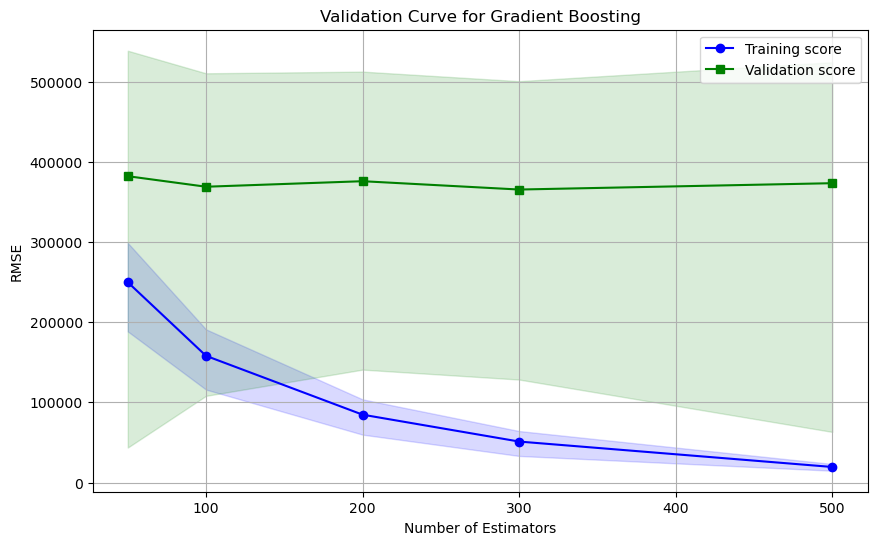

In [51]:
from sklearn.model_selection import validation_curve
import matplotlib.pyplot as plt
import numpy as np

# No need to redefine best_gb_energy with best_params manually

# Define the parameter range for 'n_estimators' you want to explore
param_range = np.array([50, 100, 200, 300, 500])

# Use validation_curve
train_scores, test_scores = validation_curve(
    estimator=GradientBoostingRegressor(learning_rate=best_gb_energy.learning_rate,
                                         max_depth=best_gb_energy.max_depth,
                                         min_samples_split=best_gb_energy.min_samples_split,
                                         min_samples_leaf=best_gb_energy.min_samples_leaf,
                                         max_features=best_gb_energy.max_features,
                                         subsample=best_gb_energy.subsample),
    X=X_train_actual_energy,
    y=y_train_actual_energy,
    param_name="n_estimators",
    param_range=param_range,
    cv=3,
    scoring="neg_mean_squared_error",
    n_jobs=-1
)

# Calculate mean and standard deviation for training and test set scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plotting the validation curve
plt.figure(figsize=(10, 6))
plt.plot(param_range, np.sqrt(-train_mean), label="Training score", color="blue", marker='o')
plt.fill_between(param_range, np.sqrt(-train_mean - train_std), np.sqrt(-train_mean + train_std), color="blue", alpha=0.15)
plt.plot(param_range, np.sqrt(-test_mean), label="Validation score", color="green", marker='s')
plt.fill_between(param_range, np.sqrt(-test_mean - test_std), np.sqrt(-test_mean + test_std), color="green", alpha=0.15)

plt.title("Validation Curve for Gradient Boosting")
plt.xlabel("Number of Estimators")
plt.ylabel("RMSE")
plt.legend(loc="best")
plt.grid(True) 
plt.show()


# Hyper Parameter Tunning on the Random Forest Model for Energy Consumption

In [52]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from math import sqrt
from sklearn.metrics import mean_squared_error

# Define the parameter grid for the random forest model on energy data
param_grid_energy_rf = {
    'n_estimators': [50, 100, 200, 300, 500],
    'max_depth': [3, 4, 5, 6, 7, 8, None],  
    'min_samples_split': [2, 4, 6, 8],
    'min_samples_leaf': [1, 2, 3, 4],
    'max_features': ['auto', 'sqrt', 'log2'],  
    'bootstrap': [True, False]  
}

# Initialize Random Forest Regressor
rf_energy = RandomForestRegressor()

# Create the grid search object
grid_search_energy_rf = GridSearchCV(estimator=rf_energy, param_grid=param_grid_energy_rf, 
                                     scoring='neg_mean_squared_error', 
                                     cv=3, n_jobs=-1, verbose=2)

# Fit the grid search object to the energy consumption data
grid_search_energy_rf.fit(X_train_actual_energy, y_train_actual_energy)

# Print the best parameters and estimator
print("Best parameters found for energy data using Random Forest: ", grid_search_energy_rf.best_params_)
rmse_score_energy_rf = sqrt(-grid_search_energy_rf.best_score_)
print("Best cross-validation score (RMSE) for energy data using Random Forest: ", rmse_score_energy_rf)

# Get the best estimator for energy data
best_rf_energy = grid_search_energy_rf.best_estimator_


Fitting 3 folds for each of 64 candidates, totalling 192 fits
Best parameters found for energy data using Random Forest:  {'bootstrap': True, 'max_depth': 3, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 50}
Best cross-validation score (RMSE) for energy data using Random Forest:  369019.4903432912


C:\Users\ROBERTECH\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
96 fits failed out of a total of 192.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
58 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\ROBERTECH\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\ROBERTECH\anaconda3\Lib\site-packages\sklearn\base.py", line 1144, in wrapper
    estimator._validate_params()
  File "C:\Users\ROBERTECH\anaconda3\Lib\site-packages\sklearn\base.py", line 637, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\ROBERTECH\anacond

In [53]:
best_rf_energy = best_rf_energy.fit(X_train_actual_energy, y_train_actual_energy)

C:\Users\ROBERTECH\AppData\Local\Temp\ipykernel_9052\1981645849.py:40: RuntimeWarning: invalid value encountered in sqrt
  plt.fill_between(param_range, train_rmse - np.sqrt(-train_std), train_rmse + np.sqrt(-train_std), color="blue", alpha=0.15)
C:\Users\ROBERTECH\AppData\Local\Temp\ipykernel_9052\1981645849.py:42: RuntimeWarning: invalid value encountered in sqrt
  plt.fill_between(param_range, test_rmse - np.sqrt(-test_std), test_rmse + np.sqrt(-test_std), color="green", alpha=0.15)


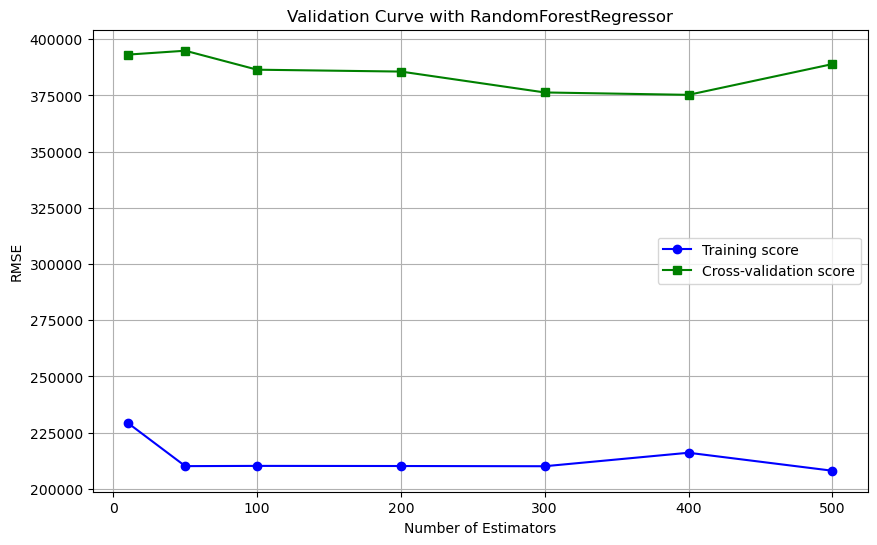

In [54]:
from sklearn.model_selection import validation_curve
import matplotlib.pyplot as plt
import numpy as np

# Define the range of values for 'n_estimators' to explore
param_range = np.array([10, 50, 100, 200, 300, 400, 500])

# Compute the validation curve
train_scores, test_scores = validation_curve(
    estimator=RandomForestRegressor(max_depth=best_rf_energy.max_depth,
                                    min_samples_split=best_rf_energy.min_samples_split,
                                    min_samples_leaf=best_rf_energy.min_samples_leaf,
                                    max_features=best_rf_energy.max_features,
                                    bootstrap=best_rf_energy.bootstrap,
                                    random_state=best_rf_energy.random_state),
    X=X_train_actual_energy, 
    y=y_train_actual_energy, 
    param_name="n_estimators", 
    param_range=param_range, 
    cv=3, 
    scoring="neg_mean_squared_error",
    n_jobs=-1
)

# Calculate mean and standard deviation for training set scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

# Calculate mean and standard deviation for test set scores
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Convert scores to RMSE
train_rmse = np.sqrt(-train_mean)
test_rmse = np.sqrt(-test_mean)

# Plot the validation curve
plt.figure(figsize=(10, 6))
plt.plot(param_range, train_rmse, label="Training score", color="blue", marker='o')
plt.fill_between(param_range, train_rmse - np.sqrt(-train_std), train_rmse + np.sqrt(-train_std), color="blue", alpha=0.15)
plt.plot(param_range, test_rmse, label="Cross-validation score", color="green", marker='s')
plt.fill_between(param_range, test_rmse - np.sqrt(-test_std), test_rmse + np.sqrt(-test_std), color="green", alpha=0.15)

plt.title("Validation Curve with RandomForestRegressor")
plt.xlabel("Number of Estimators")
plt.ylabel("RMSE")
plt.legend(loc="best")
plt.grid(True)
plt.show()

# Hyper Parameter Tunning on the Gradient Boost Model for Treated Water

In [55]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from math import sqrt
from sklearn.metrics import mean_squared_error

# Define the parameter grid
param_grid_treated = {
    'n_estimators': [50, 100, 200, 300, 500],
    'learning_rate': [0.01, 0.02, 0.05, 0.1, 0.2],
    'max_depth': [3, 4, 5, 6, 7, 8],
    'min_samples_split': [2, 4, 6, 8],
    'min_samples_leaf': [1, 2, 3, 4],
    'max_features': [None, 'sqrt', 'log2', 'auto'],
    'subsample': [0.5, 0.75, 1.0]
}

# Initialize Gradient Boosting Regressor
gb_treated = GradientBoostingRegressor()

# Create the grid search object
grid_search_treated = GridSearchCV(estimator=gb_treated, param_grid=param_grid_treated, 
                                  scoring='neg_mean_squared_error', 
                                  cv=3, n_jobs=-1, verbose=2)

# Fit the grid search object to the treated water data
grid_search_treated.fit(X_train_actual, y_train_treated_actual)

# Print the best parameters and estimator
print("Best parameters found for treated data: ", grid_search_treated.best_params_)
rmse_score = sqrt(-grid_search_treated.best_score_)
print("Best cross-validation score (RMSE) for treated data: ", rmse_score)

# Get the best estimator for treated water data
best_gb_treated = grid_search_treated.best_estimator_


Fitting 3 folds for each of 128 candidates, totalling 384 fits
Best parameters found for treated data:  {'learning_rate': 0.02, 'max_depth': 4, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100, 'subsample': 0.75}
Best cross-validation score (RMSE) for treated data:  0.8970213925138534


In [57]:
best_gb_treated = best_gb_treated.fit(X_train_actual, y_train_treated_actual)

C:\Users\ROBERTECH\AppData\Local\Temp\ipykernel_9052\319011759.py:40: RuntimeWarning: invalid value encountered in sqrt
  plt.fill_between(param_range, train_rmse - np.sqrt(-train_std), train_rmse + np.sqrt(-train_std), color="blue", alpha=0.15)
C:\Users\ROBERTECH\AppData\Local\Temp\ipykernel_9052\319011759.py:42: RuntimeWarning: invalid value encountered in sqrt
  plt.fill_between(param_range, test_rmse - np.sqrt(-test_std), test_rmse + np.sqrt(-test_std), color="green", alpha=0.15)


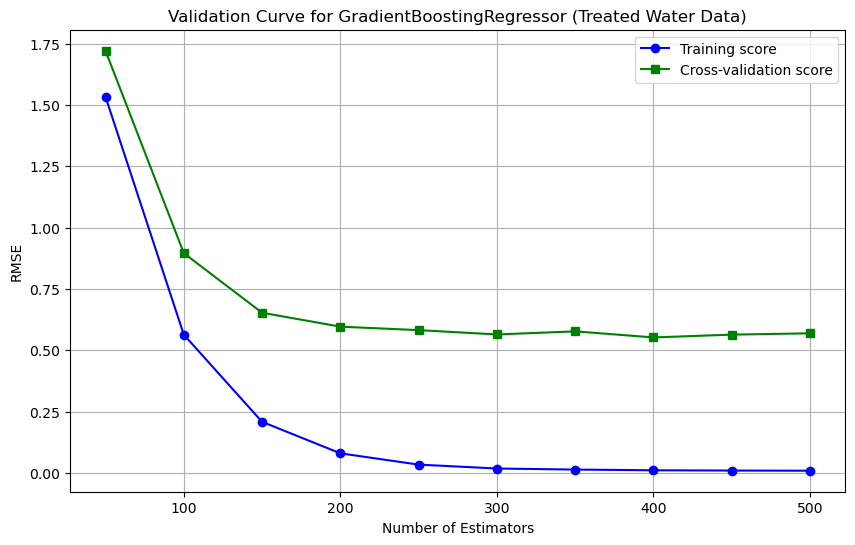

In [58]:
from sklearn.model_selection import validation_curve
import matplotlib.pyplot as plt
import numpy as np

# Define the range of 'n_estimators' to explore
param_range = np.linspace(50, 500, 10).astype(int)  # For finer granularity, adjust as needed

# Use validation_curve to evaluate the model performance over the defined range of 'n_estimators'
train_scores, test_scores = validation_curve(
    estimator=GradientBoostingRegressor(learning_rate=best_gb_treated.learning_rate,
                                         max_depth=best_gb_treated.max_depth,
                                         min_samples_split=best_gb_treated.min_samples_split,
                                         min_samples_leaf=best_gb_treated.min_samples_leaf,
                                         max_features=best_gb_treated.max_features,
                                         subsample=best_gb_treated.subsample),
    X=X_train_actual, 
    y=y_train_treated_actual, 
    param_name="n_estimators", 
    param_range=param_range, 
    cv=3, 
    scoring="neg_mean_squared_error",
    n_jobs=-1
)

# Calculate mean and standard deviation for training set scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

# Calculate mean and standard deviation for test set scores
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Convert scores to RMSE
train_rmse = np.sqrt(-train_mean)
test_rmse = np.sqrt(-test_mean)

# Plot the validation curve
plt.figure(figsize=(10, 6))
plt.plot(param_range, train_rmse, label="Training score", color="blue", marker='o')
plt.fill_between(param_range, train_rmse - np.sqrt(-train_std), train_rmse + np.sqrt(-train_std), color="blue", alpha=0.15)
plt.plot(param_range, test_rmse, label="Cross-validation score", color="green", marker='s')
plt.fill_between(param_range, test_rmse - np.sqrt(-test_std), test_rmse + np.sqrt(-test_std), color="green", alpha=0.15)

plt.title("Validation Curve for GradientBoostingRegressor (Treated Water Data)")
plt.xlabel("Number of Estimators")
plt.ylabel("RMSE")
plt.legend(loc="best")
plt.grid(True)
plt.show()

# Hyper Parameter Tunning on the Random Forest Model for Energy Consumption

In [63]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from math import sqrt
from sklearn.metrics import mean_squared_error

# Define the parameter grid for the Random Forest model
param_grid_treated_rf = {
    'n_estimators': [50, 100, 200, 300, 500],
    'max_depth': [3, 4, 5, 6, 7, 8, None],  
    'min_samples_split': [2, 4, 6, 8],
    'min_samples_leaf': [1, 2, 3, 4],
    'max_features': ['auto', 'sqrt', 'log2'],  
    'bootstrap': [True, False] 
}

# Initialize Random Forest Regressor
rf_treated = RandomForestRegressor()

# Create the grid search object
grid_search_treated_rf = GridSearchCV(estimator=rf_treated, param_grid=param_grid_treated_rf, 
                                     scoring='neg_mean_squared_error', 
                                     cv=3, n_jobs=-1, verbose=2)

# Fit the grid search object to the treated data
grid_search_treated_rf.fit(X_train_actual, y_train_treated_actual)

# Print the best parameters and estimator
print("Best parameters found for treated data using Random Forest: ", grid_search_treated_rf.best_params_)
rmse_score_rf = sqrt(-grid_search_treated_rf.best_score_)
print("Best cross-validation score (RMSE) for treated data using Random Forest: ", rmse_score_rf)

# Get the best estimator for treated data
best_rf_treated = grid_search_treated_rf.best_estimator_


Fitting 3 folds for each of 64 candidates, totalling 192 fits


C:\Users\ROBERTECH\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
96 fits failed out of a total of 192.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
54 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\ROBERTECH\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\ROBERTECH\anaconda3\Lib\site-packages\sklearn\base.py", line 1144, in wrapper
    estimator._validate_params()
  File "C:\Users\ROBERTECH\anaconda3\Lib\site-packages\sklearn\base.py", line 637, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\ROBERTECH\anacond

Best parameters found for treated data using Random Forest:  {'bootstrap': True, 'max_depth': 4, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 100}
Best cross-validation score (RMSE) for treated data using Random Forest:  0.9227980389175459


In [64]:
best_rf_treated = best_rf_treated.fit(X_train_actual, y_train_treated_actual)

# Validation curve on the best GB model for Treated Water

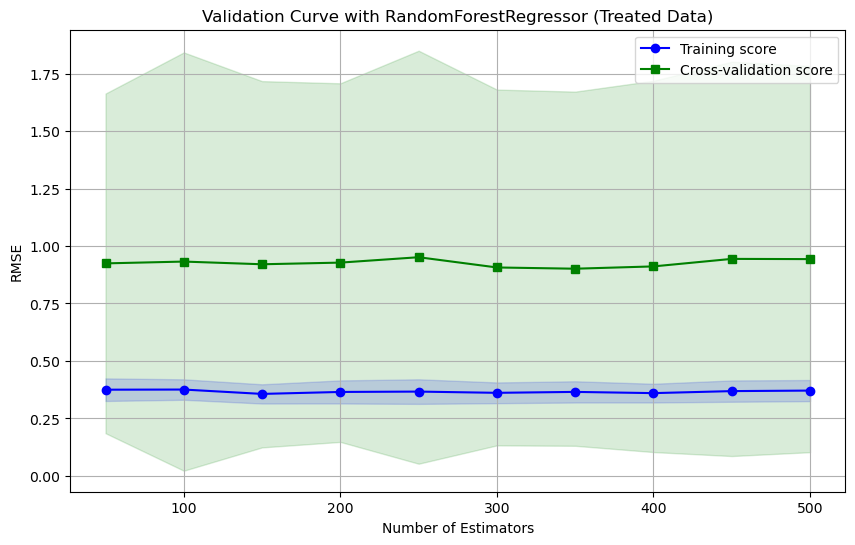

In [65]:
from sklearn.model_selection import validation_curve
import matplotlib.pyplot as plt
import numpy as np

# Assuming X_train_actual and y_train_treated_actual are defined and represent your training data

# Define the range of 'n_estimators' to explore
param_range = np.linspace(50, 500, 10).astype(int)  # Adjust the range as needed

# Use validation_curve to evaluate the model performance over the defined range of 'n_estimators'
train_scores, test_scores = validation_curve(
    estimator=RandomForestRegressor(max_depth=best_rf_treated.max_depth,
                                    min_samples_split=best_rf_treated.min_samples_split,
                                    min_samples_leaf=best_rf_treated.min_samples_leaf,
                                    max_features=best_rf_treated.max_features,
                                    bootstrap=best_rf_treated.bootstrap,
                                    random_state=best_rf_treated.random_state),
    X=X_train_actual, 
    y=y_train_treated_actual, 
    param_name="n_estimators", 
    param_range=param_range, 
    cv=3, 
    scoring="neg_mean_squared_error",
    n_jobs=-1
)

# Calculate mean and standard deviation for training set scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

# Calculate mean and standard deviation for test set scores
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Convert scores to RMSE
train_rmse = np.sqrt(-train_mean)
test_rmse = np.sqrt(-test_mean)

# Plot the validation curve
plt.figure(figsize=(10, 6))
plt.plot(param_range, train_rmse, label="Training score", color="blue", marker='o')
plt.fill_between(param_range, train_rmse - train_std, train_rmse + train_std, color="blue", alpha=0.15)
plt.plot(param_range, test_rmse, label="Cross-validation score", color="green", marker='s')
plt.fill_between(param_range, test_rmse - test_std, test_rmse + test_std, color="green", alpha=0.15)

plt.title("Validation Curve with RandomForestRegressor (Treated Data)")
plt.xlabel("Number of Estimators")
plt.ylabel("RMSE")
plt.legend(loc="best")
plt.grid(True)
plt.show()


# Prediction and Evaluation on the best tuned model for Treated Water and Energy Consumption

In [66]:

# --- GB Model Predictions and Evaluations ---
y_pred_train_energy_gb = best_gb_energy.predict(X_train_actual_energy)
rmse_train_energy_gb = sqrt(mean_squared_error(y_train_actual_energy, y_pred_train_energy_gb))
mae_train_energy_gb = mean_absolute_error(y_train_actual_energy, y_pred_train_energy_gb)
error_train_energy_gb = error(y_train_actual_energy, y_pred_train_energy_gb)

y_pred_test_energy_gb = best_gb_energy.predict(X_test_actual_energy)
rmse_test_energy_gb = sqrt(mean_squared_error(y_test_actual_energy, y_pred_test_energy_gb))
mae_test_energy_gb = mean_absolute_error(y_test_actual_energy, y_pred_test_energy_gb)
error_test_energy_gb = error(y_test_actual_energy, y_pred_test_energy_gb)

print("=== GB Model Evaluation for Energy Consumption ===")
print("\n--- Training Set ---")
print(f"RMSE: {rmse_train_energy_gb:.4f}")
print(f"MAE: {mae_train_energy_gb:.4f}")
print(f"Error Rate: {error_train_energy_gb:.4f}")

print("\n--- Test Set ---")
print(f"RMSE: {rmse_test_energy_gb:.4f}")
print(f"MAE: {mae_test_energy_gb:.4f}")
print(f"Error Rate: {error_test_energy_gb:.4f}\n")


# --- RF Model Predictions and Evaluations ---
y_pred_train_energy_rf = best_rf_energy.predict(X_train_actual_energy)
rmse_train_energy_rf = sqrt(mean_squared_error(y_train_actual_energy, y_pred_train_energy_rf))
mae_train_energy_rf = mean_absolute_error(y_train_actual_energy, y_pred_train_energy_rf)
error_train_energy_rf = error(y_train_actual_energy, y_pred_train_energy_rf)

y_pred_test_energy_rf = best_rf_energy.predict(X_test_actual_energy)
rmse_test_energy_rf = sqrt(mean_squared_error(y_test_actual_energy, y_pred_test_energy_rf))
mae_test_energy_rf = mean_absolute_error(y_test_actual_energy, y_pred_test_energy_rf)
error_test_energy_rf = error(y_test_actual_energy, y_pred_test_energy_rf)

print("=== RF Model Evaluation for Energy Consumption ===")
print("\n--- Training Set ---")
print(f"RMSE: {rmse_train_energy_rf:.4f}")
print(f"MAE: {mae_train_energy_rf:.4f}")
print(f"Error Rate: {error_train_energy_rf:.4f}")

print("\n--- Test Set ---")
print(f"RMSE: {rmse_test_energy_rf:.4f}")
print(f"MAE: {mae_test_energy_rf:.4f}")
print(f"Error Rate: {error_test_energy_rf:.4f}\n")




=== GB Model Evaluation for Energy Consumption ===

--- Training Set ---
RMSE: 157937.5303
MAE: 96680.5500
Error Rate: 1.0000

--- Test Set ---
RMSE: 551359.4442
MAE: 411785.1325
Error Rate: 1.0000

=== RF Model Evaluation for Energy Consumption ===

--- Training Set ---
RMSE: 222708.2354
MAE: 125569.7225
Error Rate: 1.0000

--- Test Set ---
RMSE: 605808.1020
MAE: 458913.6136
Error Rate: 1.0000



In [67]:
# --- GB Model Predictions and Evaluations ---
y_pred_train_treated_gb = best_gb_treated.predict(X_train_actual)
rmse_train_treated_gb = sqrt(mean_squared_error(y_train_treated_actual, y_pred_train_treated_gb))
mae_train_treated_gb = mean_absolute_error(y_train_treated_actual, y_pred_train_treated_gb)
error_train_treated_gb = error(y_train_treated_actual, y_pred_train_treated_gb)

y_pred_test_treated_gb = best_gb_treated.predict(X_test_actual)
rmse_test_treated_gb = sqrt(mean_squared_error(y_test_treated_actual, y_pred_test_treated_gb))
mae_test_treated_gb = mean_absolute_error(y_test_treated_actual, y_pred_test_treated_gb)
error_test_treated_gb = error(y_test_treated_actual, y_pred_test_treated_gb)

print("=== GB Model Evaluation for Treated Water ===")
print("\n--- Training Set ---")
print(f"RMSE: {rmse_train_treated_gb:.4f}")
print(f"MAE: {mae_train_treated_gb:.4f}")
print(f"Error Rate: {error_train_treated_gb:.4f}")

print("\n--- Test Set ---")
print(f"RMSE: {rmse_test_treated_gb:.4f}")
print(f"MAE: {mae_test_treated_gb:.4f}")
print(f"Error Rate: {error_test_treated_gb:.4f}\n")


# --- RF Model Predictions and Evaluations ---
y_pred_train_treated_rf = best_rf_treated.predict(X_train_actual)
rmse_train_treated_rf = sqrt(mean_squared_error(y_train_treated_actual, y_pred_train_treated_rf))
mae_train_treated_rf = mean_absolute_error(y_train_treated_actual, y_pred_train_treated_rf)
error_train_treated_rf = error(y_train_treated_actual, y_pred_train_treated_rf)

y_pred_test_treated_rf = best_rf_treated.predict(X_test_actual)
rmse_test_treated_rf = sqrt(mean_squared_error(y_test_treated_actual, y_pred_test_treated_rf))
mae_test_treated_rf = mean_absolute_error(y_test_treated_actual, y_pred_test_treated_rf)
error_test_treated_rf = error(y_test_treated_actual, y_pred_test_treated_rf)

print("=== RF Model Evaluation for Treated Water ===")
print("\n--- Training Set ---")
print(f"RMSE: {rmse_train_treated_rf:.4f}")
print(f"MAE: {mae_train_treated_rf:.4f}")
print(f"Error Rate: {error_train_treated_rf:.4f}")

print("\n--- Test Set ---")
print(f"RMSE: {rmse_test_treated_rf:.4f}")
print(f"MAE: {mae_test_treated_rf:.4f}")
print(f"Error Rate: {error_test_treated_rf:.4f}\n")




=== GB Model Evaluation for Treated Water ===

--- Training Set ---
RMSE: 0.5624
MAE: 0.4259
Error Rate: 0.1951

--- Test Set ---
RMSE: 1.2618
MAE: 0.9435
Error Rate: 0.5686

=== RF Model Evaluation for Treated Water ===

--- Training Set ---
RMSE: 0.3714
MAE: 0.2107
Error Rate: 0.1032

--- Test Set ---
RMSE: 1.3932
MAE: 0.9027
Error Rate: 0.5014



# Prediction and visualization on Training, Test and Validation Dataset for Treated Water

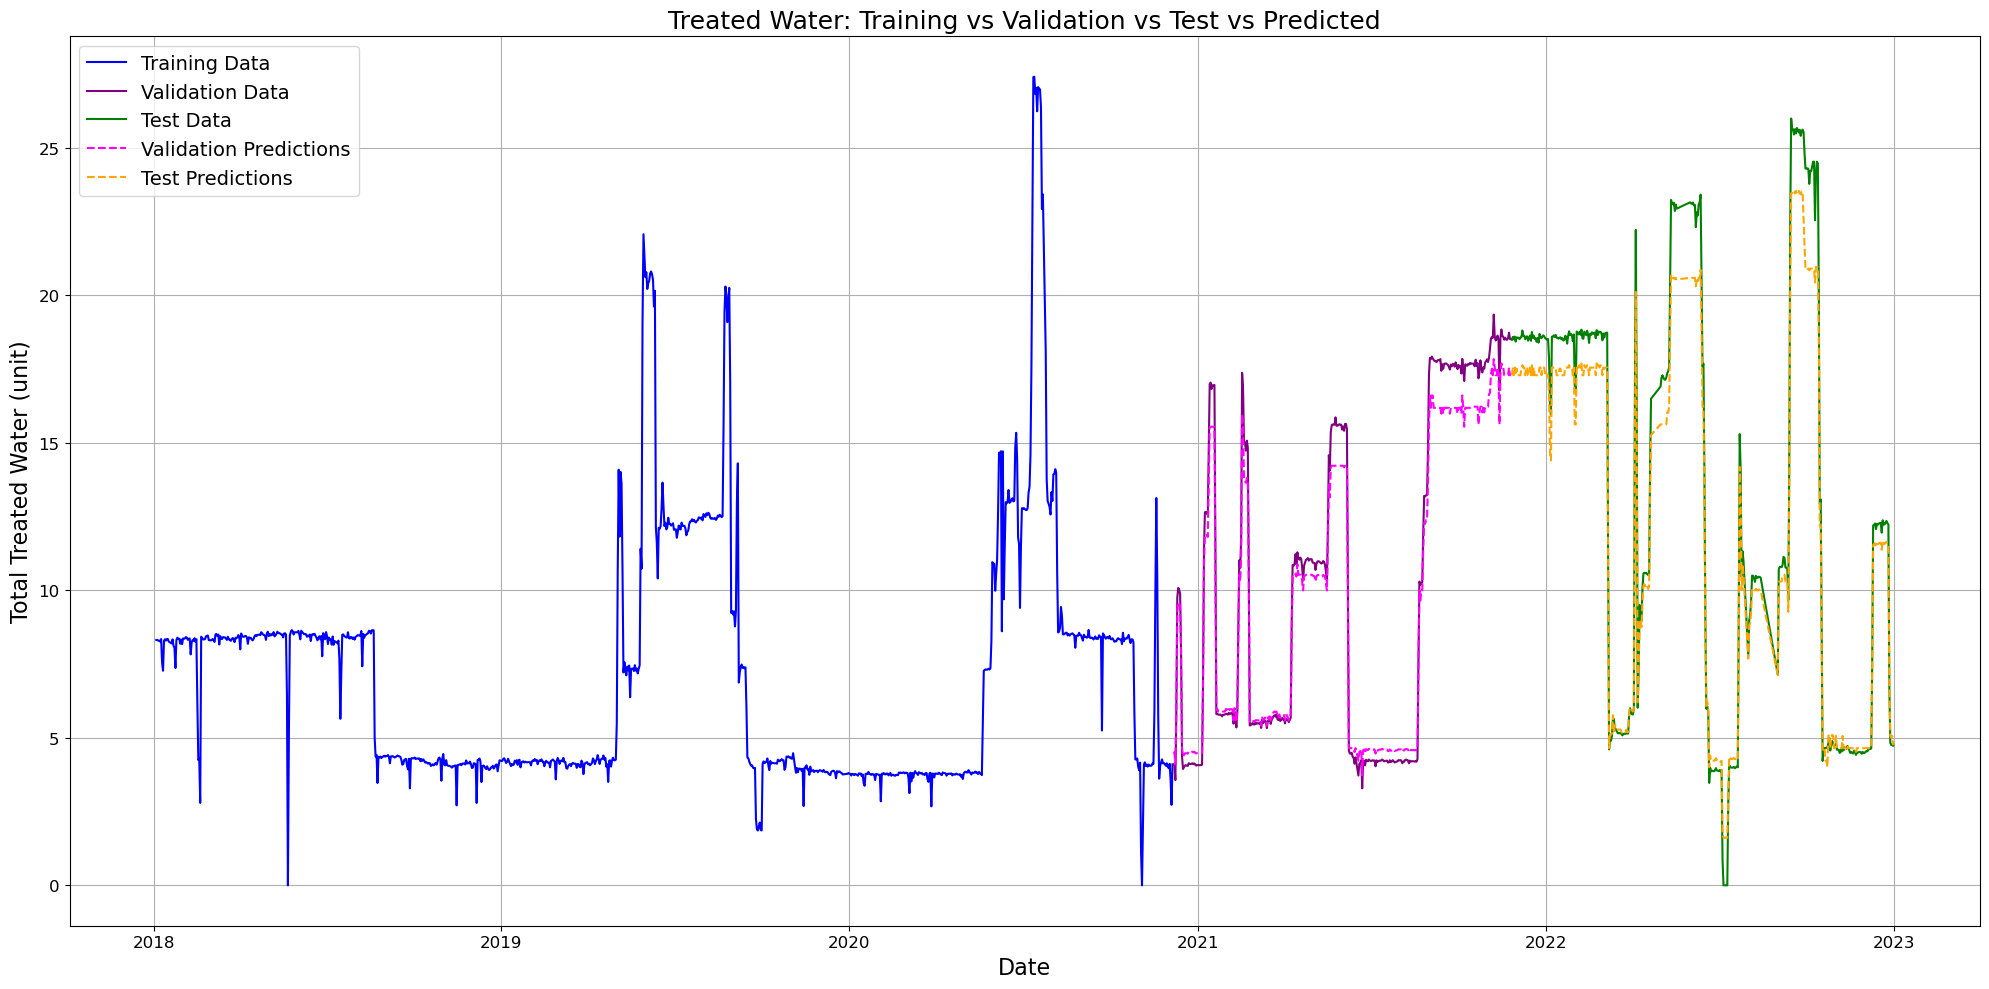

In [70]:
import matplotlib.pyplot as plt

# Set the figure size
plt.figure(figsize=(20, 10))

# Assuming the "train", "validation", and "test" dataframes have a 'Date' column for the x-axis

# Plot Training Data
train_plot, = plt.plot(train['Date'], y_train_treated_actual, label='Training Data', color='blue')

# Plot Validation Data
validation_plot, = plt.plot(validation['Date'], y_validation_treated_actual, label='Validation Data', color='purple')

# Plot Test Data
test_plot, = plt.plot(test['Date'], y_test_treated_actual, label='Test Data', color='green')

# Overlay Predicted Data for Validation from our best GB model
predicted_validation = best_gb_treated.predict(X_validation_actual) 
validation_predicted_plot, = plt.plot(validation['Date'], predicted_validation, label='Validation Predictions', color='magenta', linestyle='--')

# Overlay Predicted Data for Test from our best GB model
predicted_treated = best_gb_treated.predict(X_test_actual)
test_predicted_plot, = plt.plot(test['Date'], predicted_treated, label='Test Predictions', color='orange', linestyle='--')

# Add titles, labels, and legend with increased font sizes
plt.title('Treated Water: Training vs Validation vs Test vs Predicted', fontsize=18)
plt.xlabel('Date', fontsize=16)
plt.ylabel('Total Treated Water (unit)', fontsize=16)  # Adjust the unit as per your data
plt.legend(handles=[train_plot, validation_plot, test_plot, validation_predicted_plot, test_predicted_plot], fontsize=14)
plt.grid(True)

# Increase the size of tick labels
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Show the plot
plt.tight_layout()
plt.show()



# Prediction and visualization on Training, Test and Validation Dataset for Energy Consumption

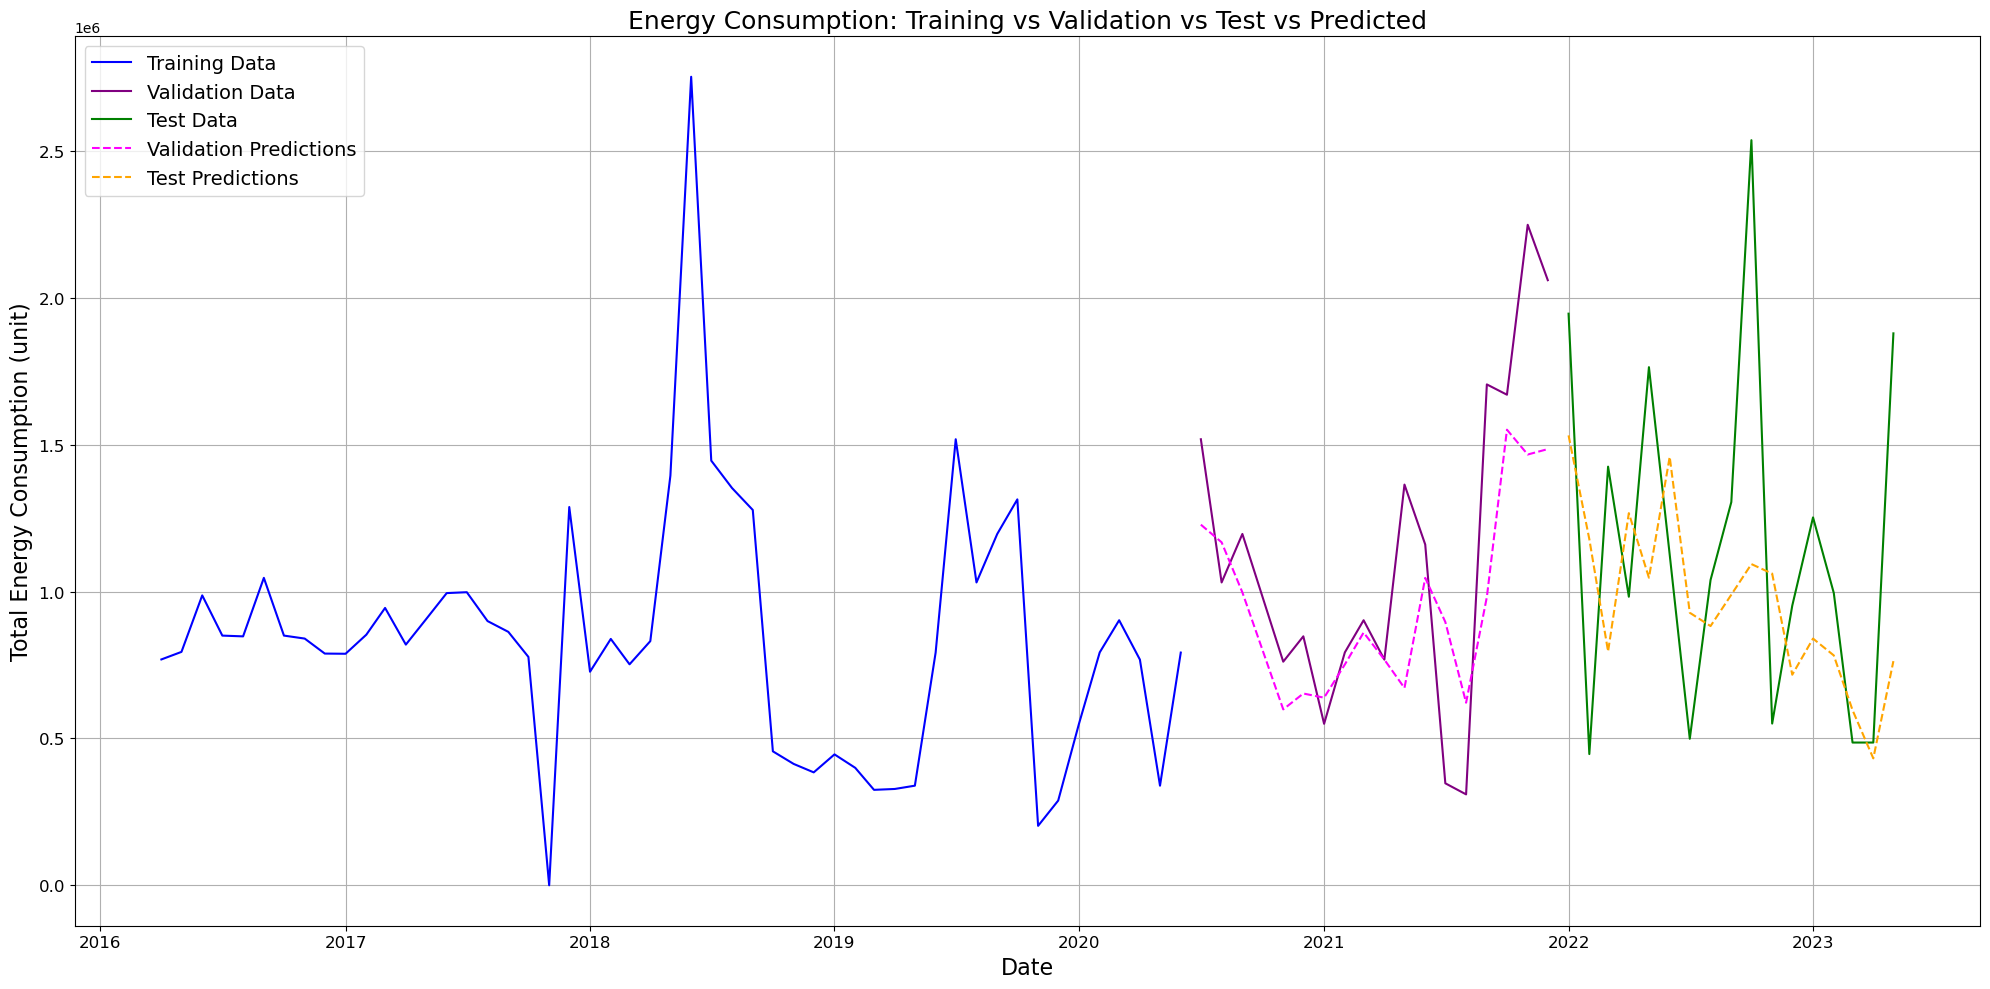

In [71]:
import matplotlib.pyplot as plt

# Set the figure size
plt.figure(figsize=(20, 10))

# Assuming the "train_energy", "validation_energy", and "test_energy" dataframes have a 'Date' column for the x-axis

# Plot Training Data for Energy Consumption
train_energy_plot, = plt.plot(train_energy['Date'], y_train_actual_energy, label='Training Data', color='blue')

# Plot Validation Data for Energy Consumption
validation_energy_plot, = plt.plot(validation_energy['Date'], y_validation_actual_energy, label='Validation Data', color='purple')

# Plot Test Data for Energy Consumption
test_energy_plot, = plt.plot(test_energy['Date'], y_test_actual_energy, label='Test Data', color='green')

# Overlay Predicted Data for Validation from our best GB model for Energy Consumption
predicted_validation_energy = gb_energy_best.predict(X_validation_actual_energy)
validation_predicted_energy_plot, = plt.plot(validation_energy['Date'], predicted_validation_energy, label='Validation Predictions', color='magenta', linestyle='--')

# Overlay Predicted Data for Test from our best GB model for Energy Consumption
predicted_energy = gb_energy_best.predict(X_test_actual_energy)
test_predicted_energy_plot, = plt.plot(test_energy['Date'], predicted_energy, label='Test Predictions', color='orange', linestyle='--')

# Add titles, labels, and legend with increased font sizes
plt.title('Energy Consumption: Training vs Validation vs Test vs Predicted', fontsize=18)
plt.xlabel('Date', fontsize=16)
plt.ylabel('Total Energy Consumption (unit)', fontsize=16)  # Adjust the unit as per your data
plt.legend(handles=[train_energy_plot, validation_energy_plot, test_energy_plot, validation_predicted_energy_plot, test_predicted_energy_plot], fontsize=14)
plt.grid(True)

# Increase the size of tick labels
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Show the plot
plt.tight_layout()
plt.show()


# 5 years prediction and visualization from best model

In [71]:
import random

# Initialize lists to store predictions
treated_predictions = []
energy_predictions = []

In [72]:
# Number of loops needed to reach 1825 predictions
n_loops = 1825 // len(X_train_actual)  # Integer division to get full loops
remaining_rows = 1825 % len(X_train_actual)  # Remaining rows after full loops

In [74]:
# Number of loops needed to reach 60 predictions
n_loops = 60 // len(X_train_actual_energy)  # Integer division to get full loops
remaining_rows_energy = 60 % len(X_train_actual_energy)  # Remaining rows after full loops

In [75]:
X_future_flow = X_train_actual.iloc[:1825].reset_index(drop=True)

X_future_energy = X_train_actual_energy.iloc[:60].reset_index(drop=True)

In [76]:
X_future_energy

,Year,Billed $,$/KWH,Water Kgal,KWH/Kgal,E Billed per Kgal,Month_Aug,Month_Dec,Month_Feb,Month_Feb,...,Month_Jul,Month_Jun,Month_Mar,Month_May,Month_Nov,Month_Oct,Month_Sep,energy_Lag_1,energy_Lag_2,energy_Lag_3
0,2016,56103.62,0.072951,217626.0,3.533847,0.257798,False,False,False,False,...,False,False,False,False,False,False,False,637308.00,384347.00,408581.00
1,2016,58179.68,0.073204,271849.0,2.923524,0.214015,False,False,False,False,...,False,False,False,True,False,False,False,769057.00,637308.00,384347.00
2,2016,93261.56,0.094475,250467.0,3.941254,0.372351,False,False,False,False,...,False,True,False,False,False,False,False,794757.00,769057.00,637308.00
3,2016,89740.36,0.105554,255110.0,3.332621,0.351771,False,False,False,False,...,True,False,False,False,False,False,False,987154.00,794757.00,769057.00
4,2016,89147.44,0.105177,253356.0,3.345459,0.351866,True,False,False,False,...,False,False,False,False,False,False,False,850185.00,987154.00,794757.00
5,2016,107524.66,0.102713,247471.0,4.230164,0.434494,False,False,False,False,...,False,False,False,False,False,False,True,847592.00,850185.00,987154.00
6,2016,66742.03,0.078500,243220.0,3.495687,0.274410,False,False,False,False,...,False,False,False,False,False,True,False,1046843.00,847592.00,850185.00
7,2016,56369.48,0.067099,227702.0,3.689432,0.247558,False,False,False,False,...,False,False,False,False,True,False,False,850220.92,1046843.00,847592.00
8,2016,53003.31,0.067179,256771.0,3.072742,0.206422,False,True,False,False,...,False,False,False,False,False,False,False,840091.00,850220.92,1046843.00
9,2017,53910.17,0.068383,254212.0,3.101179,0.212068,False,False,False,False,...,False,False,False,False,False,False,False,788991.00,840091.00,850220.92


In [77]:
# Add the remaining rows
if remaining_rows > 0:
    X_future_flow = pd.concat([X_future_flow, X_train_actual.iloc[:remaining_rows]], ignore_index=True)

In [78]:
# Add the remaining rows
if remaining_rows_energy > 0:
    X_future_energy = pd.concat([X_future_energy, X_train_actual_energy.iloc[:remaining_rows_energy]], ignore_index=True)

In [79]:
# Make the predictions using the Best GB models for treated waters
pred_flow = gb_treated_best.predict(X_future_flow)


# Append the predictions to the lists
treated_predictions.extend(pred_flow)



In [80]:
# Make the predictions using the Best GB models for treated waters
pred_energy = gb_energy_best.predict(X_future_energy)


# Append the predictions to the lists
energy_predictions.extend(pred_energy)


In [81]:
# Convert predictions to DataFrame
pred_flow = pd.DataFrame({
    'Treated_Water_Predictions': treated_predictions
})

In [90]:
# Convert predictions to DataFrame
pred_energy = pd.DataFrame({
    'energy_Predictions': energy_predictions
})

In [91]:
energy_predictions

[770169.6583937451,
 790324.0809536611,
 989475.2577140627,
 853790.1999876074,
 846684.5122851414,
 1042622.1879488091,
 853110.6903151248,
 840626.8430595406,
 791541.2200068753,
 789813.8400086344,
 857060.6345008764,
 940581.4030862215,
 820520.5066001579,
 905348.4649930012,
 996413.2061686415,
 992383.7740314704,
 899105.360738065,
 867151.676105739,
 776120.6496371224,
 -1111.107723660603,
 1286362.1589941084,
 730641.0675839611,
 839755.0155287248,
 752381.9983173206,
 830928.6381513686,
 1395756.8823173987,
 2748955.080605518,
 1448546.693466979,
 1352432.4340508725,
 1277398.2085814255,
 456539.6212758839,
 411431.78548880125,
 387305.86471865745,
 442365.42990452924,
 399686.10252316244,
 324911.47861656797,
 329874.91262840887,
 338176.0454694331,
 798234.3886212385,
 1517646.3507278413,
 1031055.3268948564,
 1198117.8965078262,
 1312022.381021532,
 200858.55094587337,
 287870.7328012715,
 549061.1889023335,
 788954.3674299906,
 903187.869758753,
 768437.5882644054,
 342283

In [84]:
# Generate a date column for Flow prediction
last_date = pd.to_datetime(flow['Date'].iloc[-1])
future_dates_flow = pd.date_range(start=last_date, periods=len(treated_predictions) + 1, freq='D')[1:]

In [102]:
# Generate a date column for Flow prediction
last_date_energy = pd.to_datetime(energy['Date'].iloc[-1])
future_dates_energy = pd.date_range(start=last_date, periods=len(energy_predictions) + 1, freq='M')[1:]

In [103]:
# Add the 'Date' column and rearrange it to be the first column for Flow Prediction
pred_flow['Date'] = future_dates_flow
pred_flow = pred_flow[['Date', 'Treated_Water_Predictions']]

In [104]:
# Add the 'Date' column and rearrange it to be the first column for Flow Prediction
pred_energy['Date'] = future_dates_energy
pred_energy = pred_energy[['Date', 'energy_Predictions']]

In [98]:
# Export to CSV
pred_flow.to_csv('Treated_Water_Predictions.csv', index=False)

In [99]:
# Export to CSV
pred_energy.to_csv('energy_Predictions.csv', index=False)

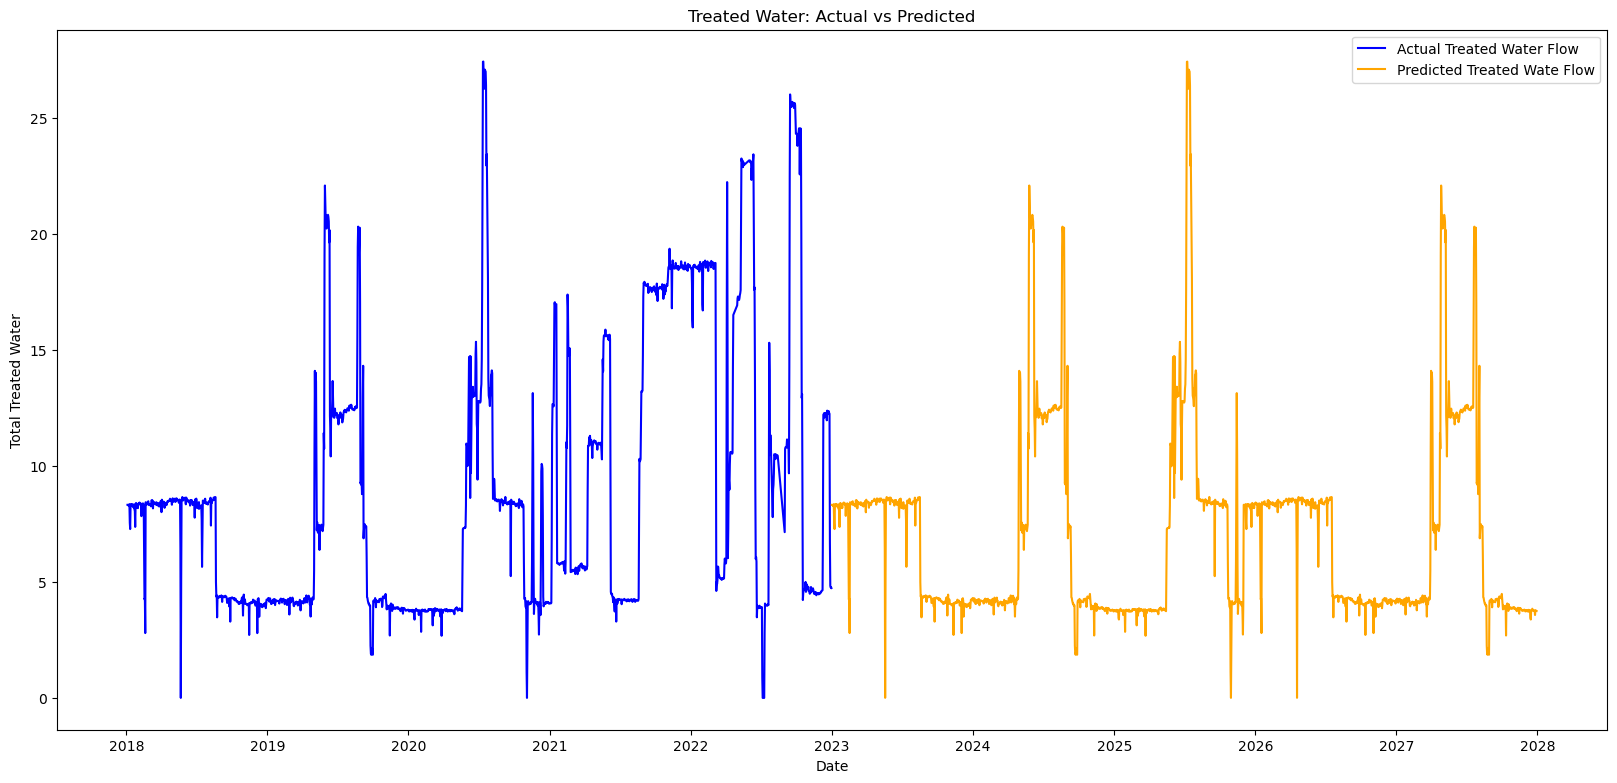

In [100]:
# Set the figure size
plt.figure(figsize=(20, 20))



# Plot  Treated Water Flow
plt.subplot(2, 1, 1)
plt.plot(flow['Date'], flow['Total Flow4'], label='Actual Treated Water Flow', color='blue')
plt.plot(pred_flow['Date'], pred_flow['Treated_Water_Predictions'], label='Predicted Treated Wate Flow', color='orange')
plt.title('Treated Water: Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('Total Treated Water')
plt.legend()


plt.savefig("Predicted Treated water for Kay Bailey Site.png", dpi=300, bbox_inches='tight')

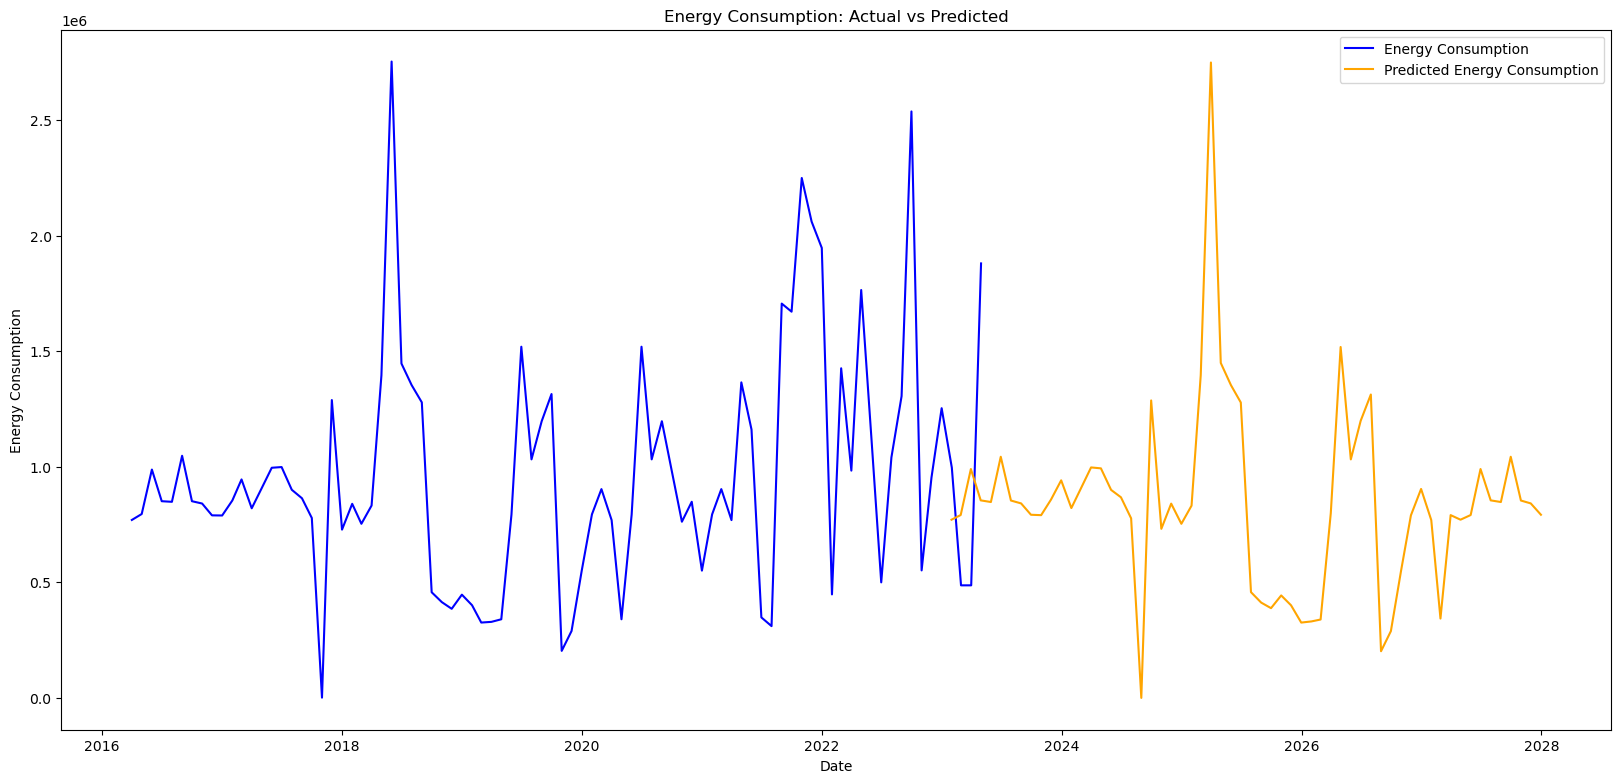

In [106]:
# Set the figure size
plt.figure(figsize=(20, 20))



# Plot  Energy Consumption
plt.subplot(2, 1, 1)
plt.plot(energy['Date'], energy['KWH'], label='Energy Consumption', color='blue')
plt.plot(pred_energy['Date'], pred_energy['energy_Predictions'], label='Predicted Energy Consumption', color='orange')
plt.title('Energy Consumption: Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('Energy Consumption')
plt.legend()


plt.savefig("Predicted Energy Consumption for Kay Bailey Site.png", dpi=300, bbox_inches='tight')


# Saving the Best Model

In [75]:
import pickle

# Saving the best Gradient Boosting model for treated water in Kay Bailey
with open('best_rf_treated.pkl', 'wb') as f:
    pickle.dump(best_rf_treated, f)
    

# Saving the best Gradient Boosting model for Energy Consumption in Kay Bailey
with open('best_gb_treated.pkl', 'wb') as f:
    pickle.dump(best_gb_treated, f)